In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

In [3]:
df = pd.read_csv('./Fog.csv')
df.drop(df.index[df[(df.values == 'X') | \
    (df.values == 'V')].index], inplace=True)
df = df.drop(['time','Label'],axis=1)
df = df.astype("float64")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19659 entries, 0 to 19679
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    19659 non-null  float64
 1   dpTemp  19659 non-null  float64
 2   RH      19659 non-null  float64
 3   WDIR    19659 non-null  float64
 4   VIZ     19659 non-null  float64
dtypes: float64(5)
memory usage: 921.5 KB


In [6]:
df.corr()['VIZ']

temp      0.328069
dpTemp    0.075895
RH       -0.436874
WDIR     -0.102396
VIZ       1.000000
Name: VIZ, dtype: float64

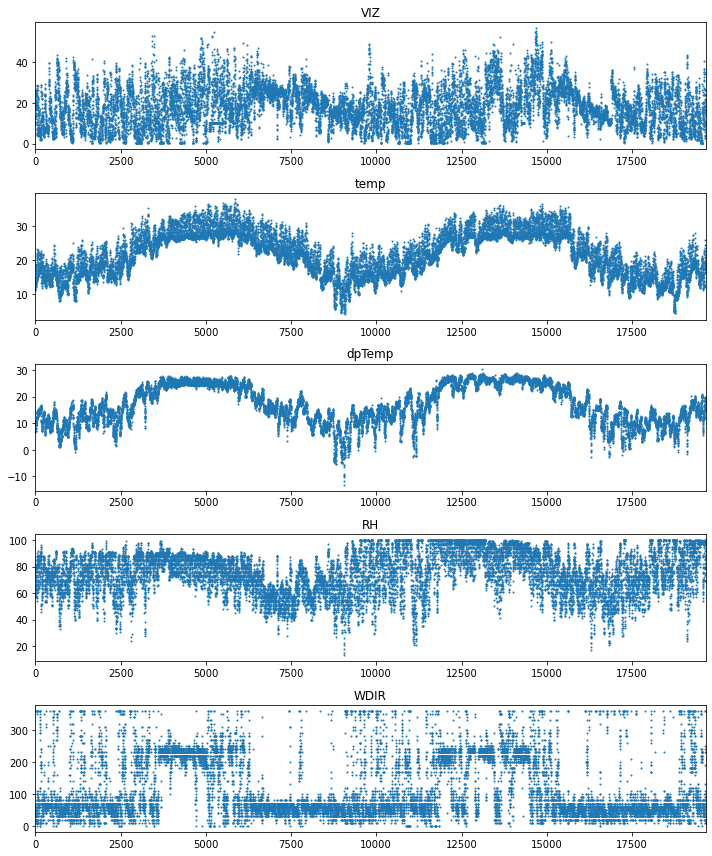

In [40]:
fig = plt.figure(figsize=(10, 12))

names = ('VIZ', 'temp', 'dpTemp', 'RH', 'WDIR')

for i in range(5):
    data = df[names[i]]
    ax = fig.add_subplot(5, 1, i + 1)
    plt.scatter(np.arange(data.size), data, s=1)
    ax.set_xlim([0, data.size])
    ax.set_title(names[i])

plt.tight_layout()
plt.show()

In [100]:
# dataset = df.drop(['VIZ'], axis=1)
dataset = df.astype('float32')
dataset

,temp,dpTemp,RH,WDIR,VIZ
0,11.400000,6.700000,73.0,60.0,10.510000
1,11.300000,6.800000,74.0,50.0,9.940000
2,11.400000,6.900000,74.0,30.0,9.890000
3,11.300000,6.800000,74.0,40.0,10.410000
4,11.500000,7.000000,74.0,50.0,11.990000
...,...,...,...,...,...
19675,18.799999,18.799999,100.0,60.0,16.790001
19676,18.700001,18.200001,97.0,40.0,18.520000
19677,18.799999,18.299999,97.0,30.0,20.629999
19678,18.600000,18.299999,98.0,10.0,15.930000


In [107]:
scaler = MinMaxScaler(feature_range=(0, 1))  # Also try QuantileTransformer
X = scaler.fit_transform(dataset)

scalerY = MinMaxScaler(feature_range=(0, 1))
Y = scalerY.fit_transform(dataset['VIZ'].values.reshape(-1, 1))
X.shape, Y.shape

((19659, 5), (19659, 1))

In [58]:
split = 0.2
slice_index = int(dataset.shape[0] * (1 - split))

train, test = dataset[:slice_index, :], dataset[slice_index:, :]
train.shape, test.shape, slice_index

((15727, 5), (3932, 5), 15727)

In [69]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        # print(dataset[i], dataset[i+seq_size, -1])
        window = dataset[i:(i+seq_size), :-1]
        x.append(window)
        y.append(dataset[i+seq_size, -1])

    return np.array(x), np.array(y)


In [70]:
lookback = 72

trainX, trainY = to_sequences(train, lookback)
testX, testY = to_sequences(test, lookback)

In [71]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((15654, 72, 4), (15654,), (3859, 72, 4), (3859,))

In [79]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, -1))
testX = np.reshape(testX, (testX.shape[0], 1, -1))

print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(64, input_shape=(None, lookback*4)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20,
#                        verbose=1, mode='auto', restore_best_weights=True)
model.summary()


Single LSTM with hidden Dense...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                90368     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 92,481
Trainable params: 92,481
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

Epoch 1/100
490/490 - 15s - loss: 0.0241 - val_loss: 0.0165 - 15s/epoch - 30ms/step
Epoch 2/100
490/490 - 3s - loss: 0.0218 - val_loss: 0.0166 - 3s/epoch - 7ms/step
Epoch 3/100
490/490 - 4s - loss: 0.0209 - val_loss: 0.0155 - 4s/epoch - 7ms/step
Epoch 4/100
490/490 - 3s - loss: 0.0203 - val_loss: 0.0156 - 3s/epoch - 6ms/step
Epoch 5/100
490/490 - 3s - loss: 0.0201 - val_loss: 0.0183 - 3s/epoch - 6ms/step
Epoch 6/100
490/490 - 3s - loss: 0.0201 - val_loss: 0.0180 - 3s/epoch - 6ms/step
Epoch 7/100
490/490 - 3s - loss: 0.0192 - val_loss: 0.0160 - 3s/epoch - 6ms/step
Epoch 8/100
490/490 - 3s - loss: 0.0194 - val_loss: 0.0175 - 3s/epoch - 6ms/step
Epoch 9/100
490/490 - 3s - loss: 0.0193 - val_loss: 0.0162 - 3s/epoch - 5ms/step
Epoch 10/100
490/490 - 3s - loss: 0.0185 - val_loss: 0.0181 - 3s/epoch - 5ms/step
Epoch 11/100
490/490 - 3s - loss: 0.0186 - val_loss: 0.0205 - 3s/epoch - 5ms/step
Epoch 12/100
490/490 - 3s - loss: 0.0184 - val_loss: 0.0213 - 3s/epoch - 5ms/step
Epoch 13/100
490/490 -

In [135]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict.shape, testPredict.shape

((15654, 1), (3859, 1))

In [125]:
trainY.shape, testY.shape

((15654,), (3859,))

In [136]:
trainPredict = scalerY.inverse_transform(trainPredict)
invTrainY = scalerY.inverse_transform([trainY])
testPredict = scalerY.inverse_transform(testPredict)
invTestY = scalerY.inverse_transform([testY])
trainPredict.shape, invTrainY.shape, testPredict.shape, invTestY.shape


((15654, 1), (1, 15654), (3859, 1), (1, 3859))

In [137]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(invTrainY[0], trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(invTestY[0], testPredict))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 6.21 RMSE
Test Score: 9.61 RMSE


In [138]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(trainPredict)+lookback, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lookback*2) +
                1:len(dataset)-1, :] = testPredict


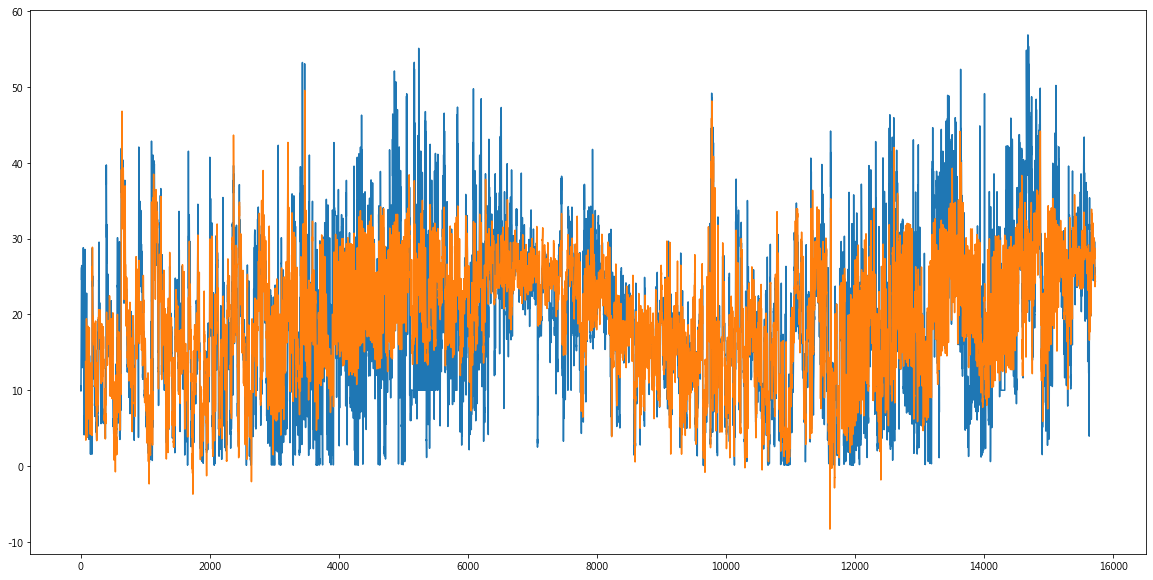

In [150]:
tmp = np.empty_like(scaler.inverse_transform(
    X)[:slice_index, 4].reshape(-1, 1))
tmp[:, :] = np.nan
tmp[lookback+1:, :] = trainPredict

plt.figure(figsize=(20, 10))
plt.plot(scaler.inverse_transform(
    X)[:slice_index, 4].reshape(-1, 1))
# plt.plot(trainPredictPlot)
plt.plot(tmp)
plt.show()


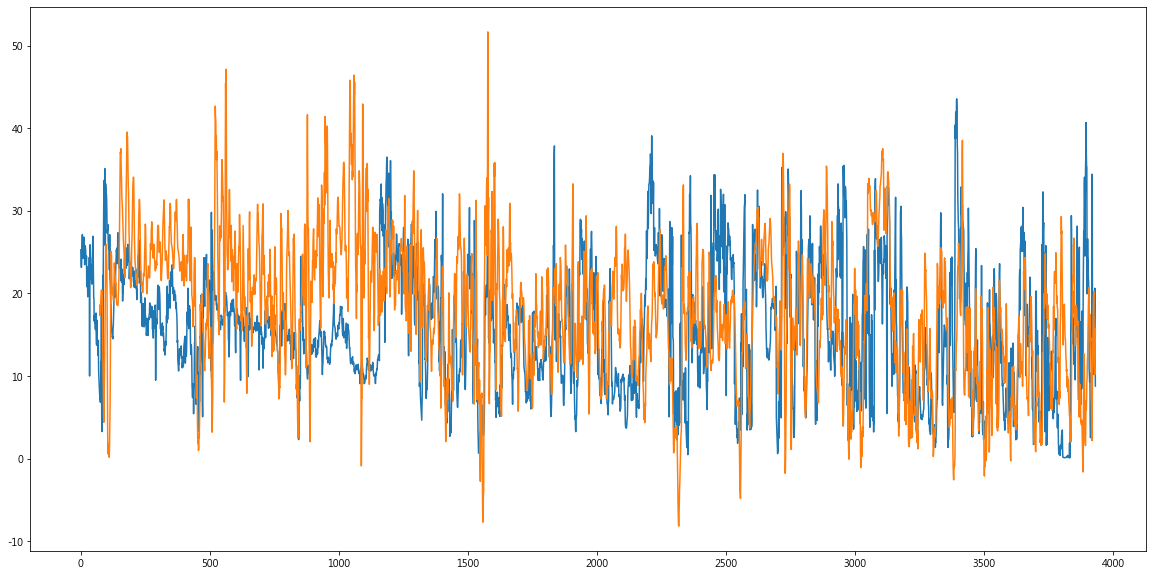

In [153]:
tmp = np.empty_like(scaler.inverse_transform(
    X)[slice_index:, 4].reshape(-1, 1))
tmp[:, :] = np.nan
tmp[lookback+1:, :] = testPredict

plt.figure(figsize=(20, 10))
plt.plot(scaler.inverse_transform(
    X)[slice_index:, 4].reshape(-1, 1))
# plt.plot(trainPredictPlot)
plt.plot(tmp)
plt.show()
